In [24]:
import matplotlib
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import os


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
dataset_dir = r'D:\Data\workspace\python\projects\CNDataAuditOutput\sichuan\datasets'
catalog_path = r'D:\Data\workspace\python\projects\CNDataAuditOutput\sichuan\dataset_catalog.json'

dtype = {'name': str, 'id': str, 'URL': str, 'owner': str, 'category': 'category',
         'published': 'datetime64[ns]', 'updated': 'datetime64[ns]',
         'frequency': 'category', 'sample_data': object}

df = pd.read_json(catalog_path, dtype=dtype)

print(df.info())

In [ ]:
df['category'].value_counts() 

In [ ]:
df['frequency'].value_counts()

In [ ]:
# Take a look at Datasets in files but not in catalog
# also Datasets in catalog but not found in files
# Directory containing datasets
files = [f for f in os.listdir(dataset_dir) if f.endswith('.csv')]
dataset_names_from_files = [os.path.splitext(f)[0] for f in files]
dataset_names_from_catalog = df['name'].tolist()

datasets_not_in_catalog = set(dataset_names_from_files) - set(dataset_names_from_catalog)
datasets_in_catalog_not_found = set(dataset_names_from_catalog) - set(dataset_names_from_files)

print(len(set(dataset_names_from_files)), len(set(dataset_names_from_catalog)))
print(len(datasets_not_in_catalog), len(datasets_in_catalog_not_found))

In [ ]:
# Find duplicates in the 'name' column
duplicates = df[df.duplicated('name', keep=False)]  # keep=False marks all duplicates as True

# Display duplicates
print("Duplicate records based on 'name':")
print(duplicates['name'].sort_values())
print(len(duplicates))

In [ ]:
def remove_files(names):
  count = 0
  for dataset_name in names:
      file_path = os.path.join(dataset_dir, f"{dataset_name}.csv")
      if os.path.exists(file_path):
          os.remove(file_path)
          count += 1
      else:
          print(f"File not found: {file_path}")
  print(count)

# remove_files(datasets_not_in_catalog)
# remove_files(set(duplicates['name'].tolist()))

In [ ]:
def remove_records(names):
  filtered_df = df[~df['name'].isin(names)]
  str_filtered_df = filtered_df.astype(str)
  # last column as type dict
  str_filtered_df['sample_data'] = filtered_df['sample_data']
  print(len(str_filtered_df))
  return str_filtered_df

# filtered = remove_records(datasets_in_catalog_not_found)
filtered = remove_records(set(duplicates['name'].tolist()))
filtered.to_json('updated_catalog.json', orient='records', force_ascii=False)

In [ ]:
# Move empty datasets (sample_data = {'null': 'null'}) 
# into a separate directory

import os
import shutil

# Directories setup
source_dir = r'D:\Data\workspace\python\projects\CNDataAuditOutput\sichuan\datasets'
destination_dir = r'D:\Data\workspace\python\projects\CNDataAuditOutput\sichuan\empty_datasets'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Creating a boolean mask for filtering
is_empty_sample = df['sample_data'].apply(lambda x: x == {'null': 'null'})
# Filtering the DataFrame to get only rows where sample_data is {"null": "null"}
empty_datasets_df = df[is_empty_sample]
print(len(empty_datasets_df))

# Iterate through the DataFrame of empty datasets
for index, row in empty_datasets_df.iterrows():
    file_name = f"{row['name']}.csv"  # Assuming the file names are directly derived from the 'name' column
    source_path = os.path.join(source_dir, file_name)
    destination_path = os.path.join(destination_dir, file_name)

    # Check if the file exists and then move it
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"Moved '{file_name}' to {destination_dir}")
    else:
        print(f"File '{file_name}' not found in {source_dir}")

In [3]:
print("Unique frequencies in the dataset:", df['frequency'].unique())

Unique frequencies in the dataset: ['每年', '不定期', '实时', '每季度', '每月', '每天', '每半年', '每周']
Categories (8, object): ['不定期', '实时', '每半年', '每周', '每天', '每季度', '每年', '每月']


In [71]:
from datetime import timedelta

# Evaluation of timeliness
def evaluate_timeliness(df):
    def is_timely(dataset, now=None):
        if now is None:
            now = pd.Timestamp.now()

        max_days = frequency_days.get(dataset['frequency'], None)
        if max_days is None:
            return None
        return now - dataset['updated'] <= timedelta(days=max_days)

    frequency_days = {
        '实时': 0,
        '每天': 1,
        '每周': 7,
        '每月': 30,
        '每季度': 90,
        '每半年': 183,
        '每年': 365,
    }

    downloaded = pd.Timestamp('2024-04-30 20:00:00')
    is_timely = partial(is_timely, now=downloaded)
    df['is_timely'] = df.apply(is_timely, axis=1)

def timeliness_freq_distribution(df):
  timely_df = df[df['is_timely'] == True]
  untimely_df = df[df['is_timely'] == False]
  return timely_df['frequency'].value_counts(), untimely_df['frequency'].value_counts()

def print_timeliness_freq_distribution():
    print("Frequency distribution for timely updates:")
    print(timely_freq_distribution)
    print("Frequency distribution for untimely updates:")
    print(untimely_freq_distribution)


def visualize_timeliness_distribution(save_path=None):
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{v:d} ({p:.2f}%)'.format(v=val, p=pct) if pct > 0 else ''
        return my_format
  
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

    timely_freq_counts = timely_freq_distribution[timely_freq_distribution > 0]
    untimely_freq_counts = untimely_freq_distribution[untimely_freq_distribution > 0]

    axes[0].pie(timely_freq_counts, labels=timely_freq_counts.index,
                autopct=autopct_format(timely_freq_counts), startangle=140)
    axes[1].pie(untimely_freq_counts, labels=untimely_freq_counts.index,
                autopct=autopct_format(timely_freq_counts), startangle=140)
    axes[0].set_title('及时更新的数据集更新频率分布')
    axes[1].set_title('未及时更新的数据集更新频率分布')
    fig.text(0.5, 0.01, '评估时间：2024-04-30 20:00:00', ha='center', va='bottom', fontsize=10)
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


timely_freq_distribution, untimely_freq_distribution = timeliness_freq_distribution(df)

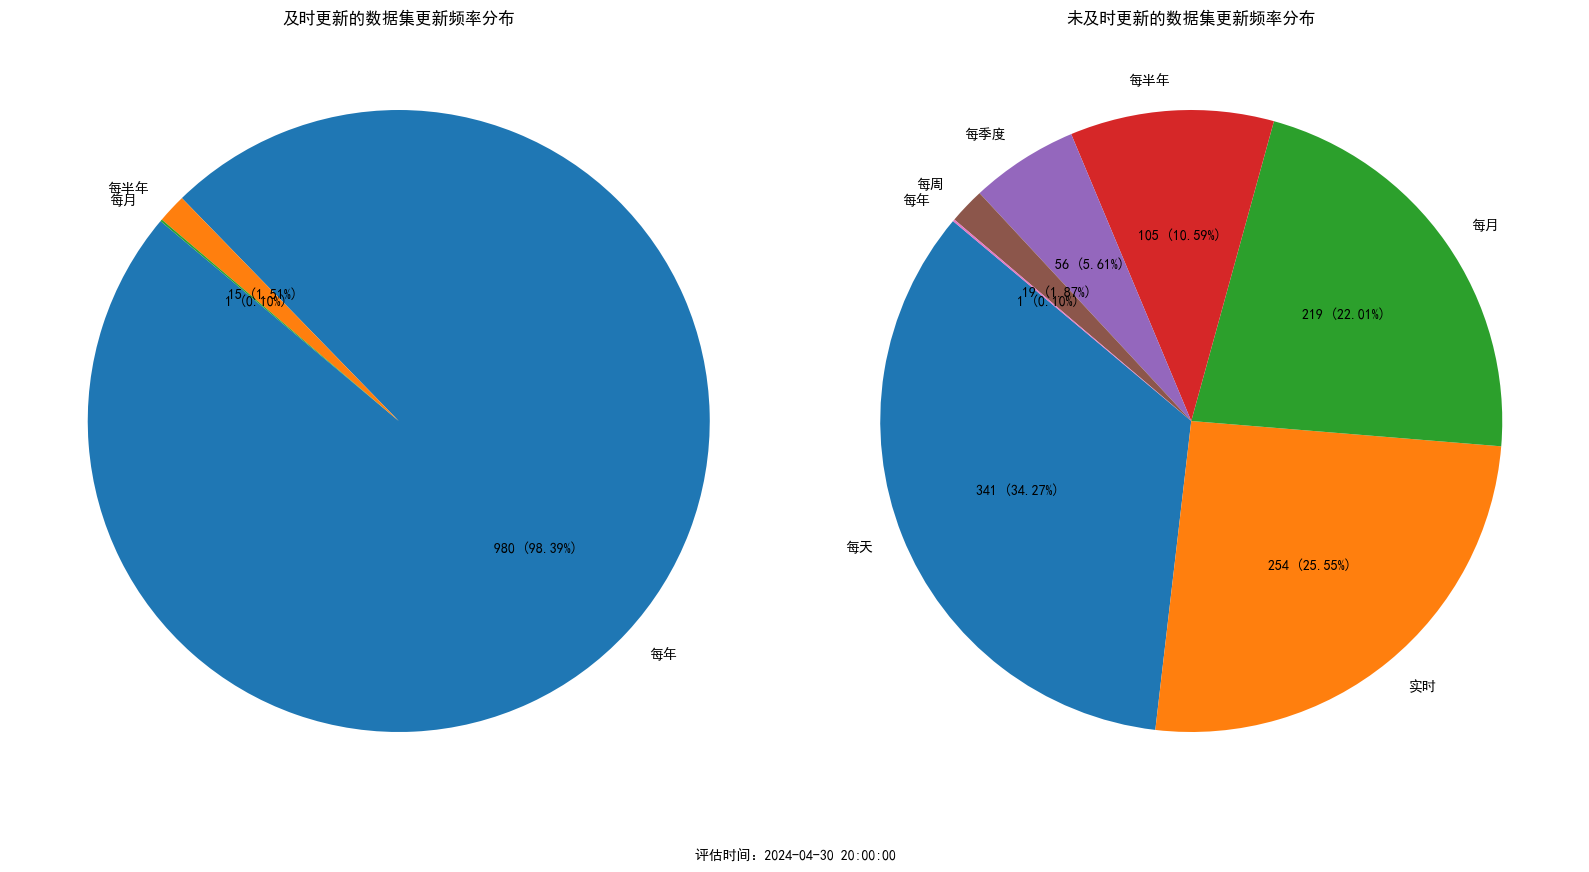

In [72]:
visualize_timeliness_distribution(save_path='timeliness_distribution.png')